# Data Ingestion

## Copy CSV files to S3

In [2]:
# Assume all the pre-requisites were set up 
%store -r setup_instance_check_passed
%store -r setup_dependencies_passed
%store -r setup_s3_bucket_passed
%store -r setup_iam_roles_passed


In [3]:
# Load Libraries
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [4]:
# Public Data
!aws s3 ls s3://ads508team5/

# Copy Datasets from :
# Source of data
s3_public_path_tweeter = "s3://ads508team5/tweeter"
s3_public_path_nyt = "s3://ads508team5/nyt"
s3_public_path_cities = "s3://ads508team5/cities"

# Destination Data:
s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)
s3_private_path_cities = "s3://{}/ADS508_project/cities".format(bucket)


# Copy datasets
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_donaldtrump.csv"
!aws s3 cp --recursive $s3_public_path_tweeter/ $s3_private_path_tweeter/ --exclude "*" --include "hashtag_joebiden.csv"
!aws s3 cp --recursive $s3_public_path_nyt/ $s3_private_path_nyt/ --exclude "*" --include "nyt-comments-2020.csv"
!aws s3 cp --recursive $s3_public_path_cities/ $s3_private_path_cities/ --exclude "*" --include "uscities.csv"

                           PRE cities/
                           PRE nyt/
                           PRE tweeter/
copy: s3://ads508team5/tweeter/hashtag_donaldtrump.csv to s3://sagemaker-us-east-1-975050119017/ADS508_project/tweeter/hashtag_donaldtrump.csv
copy: s3://ads508team5/tweeter/hashtag_joebiden.csv to s3://sagemaker-us-east-1-975050119017/ADS508_project/tweeter/hashtag_joebiden.csv
copy: s3://ads508team5/nyt/nyt-comments-2020.csv to s3://sagemaker-us-east-1-975050119017/ADS508_project/nyt/nyt-comments-2020.csv
copy: s3://ads508team5/cities/uscities.csv to s3://sagemaker-us-east-1-975050119017/ADS508_project/cities/uscities.csv


## Create Database, Tables and Parquets
### Database

In [5]:
# Setup and check pre-requisites to create Database
ingest_create_athena_db_passed = False

#!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [6]:

# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

# Create Connection
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [7]:
# Create Database
database_name = "dbpoliticpulsecomment"

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

# Verify DB successfully created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)


,database_name
0,dbpoliticpulsecomment
1,default


In [8]:
# End of Create Database
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Tables

In [9]:
# Create Tweeter Tables
table_name_csv = "tweeter"
s3_private_path_tweeter = "s3://{}/ADS508_project/tweeter".format(bucket)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
  created_at TIMESTAMP,
  tweet_id FLOAT,
  tweet VARCHAR(250),
  likes INT,
  retweet_count INT,
  source VARCHAR(45),
  user_id INT,
  user_name VARCHAR(250),
  user_screen_name VARCHAR(45),
  user_description VARCHAR(250),
  user_join_date TIMESTAMP,
  user_followers_count INT,
  user_location VARCHAR(45),
  lat FLOAT,
  long FLOAT,
  city VARCHAR(45),
  country VARCHAR(45),
  continent VARCHAR(45),
  state VARCHAR(45),
  state_code VARCHAR(45),
  collected_at VARCHAR(45)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_tweeter
)

pd.read_sql(statement, conn)


""


In [10]:
# testing hashtag_donaldtrump.csv tweet
tweet = "You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D"
# testing hashtag_joebiden.csv tweet
tweet = "@chrislongview Watching and setting dvr. Let’s give him bonus ratings!! #JoeBiden"


statement = """SELECT * FROM {}.{}
    WHERE tweet = '{}' LIMIT 100""".format(
    database_name, table_name_csv, tweet
)

df = pd.read_sql(statement, conn)
df.head(5)


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0,0,Twitter for iPhone,None,Michelle Ferg,MichelleFerg4,,...,27,,None,None,,,,,,2020-10-21 00:00:01.553481849


In [11]:
# Create NYT comment Table
table_name_csv = "nyt_comment"
s3_private_path_nyt = "s3://{}/ADS508_project/nyt".format(bucket)


statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
  commentID INT,
  status VARCHAR(20),
  commentSequence INT,
  userID INT,
  userDisplayName VARCHAR(45),
  userLocation VARCHAR(45),
  userTitle VARCHAR(10),
  commentBody VARCHAR(500),
  createDate TIMESTAMP,
  updateDate TIMESTAMP,
  approveDate TIMESTAMP,
  recommendation INT,
  replyCount INT,
  editorsSelection VARCHAR(20),
  parentID INT,
  parentUserDisplayName VARCHAR(45),
  depth INT,
  commentType VARCHAR(20),
  trusted VARCHAR(20),
  recommendedFlag VARCHAR(20),
  permID INT,
  isAnonymous VARCHAR(20),
  articleID VARCHAR(150)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_nyt
)

pd.read_sql(statement, conn)


""


In [12]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,comment
1,comment_parquet
2,nyt_comment
3,tweeter


In [13]:
commentBody = "@Philip Brown Agree 110%."

statement = """SELECT * FROM {}.{}
    WHERE commentBody = '{}' LIMIT 100""".format(
    database_name, table_name_csv, commentBody
)

df = pd.read_sql(statement, conn)
df.head(5)


,commentid,status,commentsequence,userid,userdisplayname,userlocation,usertitle,commentbody,createdate,updatedate,...,editorsselection,parentid,parentuserdisplayname,depth,commenttype,trusted,recommendedflag,permid,isanonymous,articleid
0,104389709,approved,104389709,72038931,Anthony Monaghan,Narrabeen,,@Philip Brown Agree 110%.,2020-01-01 10:36:20,2020-01-01 21:18:55,...,False,104389536,Philip Brown,2,userReply,0,0,104389709,False,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...


In [14]:
# Create uscities table
table_name = "uscities"
s3_private_path_cities = "s3://{}/ADS508_project/cities".format(bucket)

statement = """
CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
    city VARCHAR(45),
    state_id VARCHAR(2),
    state_name VARCHAR(30)
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY ','
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')
""".format(
    database_name, table_name, s3_private_path_cities
)

pd.read_sql(statement, conn)

#with conn.cursor() as cursor:
#    for _, row in df_city.iterrows():
#        cursor.execute("INSERT INTO {}.{} VALUES ('{}', '{}', '{}')".format(database_name, table_name, row['city'], row['state_id'], row['state_name']))


""


### Parquets
#### Feature Selection and Creation
Prior creating a parquet table, tweeter and NYT comment tables are going to be combined under Comment Table in Athena where a feature creation is going to be performed. When the table is combined, we selected some features that would be benefit to our goal.

Selected features which could help on train the model are comment_id, comment_body, user_id, user_location, candidatepoll

In [15]:
table_comment = "comment"
table_tweeter = "tweeter"
table_nyt_comment = "nyt_comment"

# SQL Statement combine tweeter and NYT comment in the preparation to create parquet
statement = """
CREATE TABLE IF NOT EXISTS {}.{} AS (
SELECT DISTINCT
    tweet_id AS comment_id,
    tweet AS comment_body,
    user_id AS user_id,
    user_name AS user_name,
    user_location AS user_location,
    u.state_id AS user_state,
    created_at AS create_date,
    retweet_count AS reply_retweet,
    likes AS recommendation_like,
    'tweet' as source,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE 
        WHEN 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN              
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(tweet) - LENGTH(REPLACE(LOWER(tweet), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM
    {}.{}
LEFT JOIN
    dbpoliticpulsecomment.uscities u ON lower(user_location) = lower(u.city) OR 
    lower(user_location) = lower(u.state_name) OR 
    lower(user_location) = lower(u.state_id)
WHERE
    LENGTH(tweet) > 3
UNION
SELECT DISTINCT
    commentid AS comment_id,
    commentbody AS comment_body,
    userID AS user_id,
    userDisplayName AS user_name,
    userLocation AS user_location,
    u.state_id as user_state,
    createDate AS create_date,
    replyCount AS reply_retweet,
    recommendation AS recommendation_like,
    'nyt_comment' as source,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') AS trump_count,
    (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') AS biden_count,
    CASE
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') > 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Biden'
        WHEN
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'biden', ''))) / LENGTH('biden') < 
            (LENGTH(commentbody) - LENGTH(REPLACE(LOWER(commentbody), 'trump', ''))) / LENGTH('trump') 
        THEN 'Trump'
        ELSE NULL
    END AS candidatepoll
FROM 
    {}.{}
LEFT JOIN
    dbpoliticpulsecomment.uscities u ON lower(userLocation) = lower(u.city) OR 
    lower(userLocation) = lower(u.state_name) OR 
    lower(userLocation) = lower(u.state_id)
WHERE LENGTH(commentbody) > 3
)""".format(database_name, table_comment,database_name, table_tweeter,database_name, table_nyt_comment)

pd.read_sql(statement, conn)

,rows


In [16]:
commentbody = "Joe Biden"
source = "nyt_comment"

statement = """SELECT * FROM {}.{}
    WHERE comment_body like '{}%' and source = '{}' LIMIT 100""".format(
    database_name, table_comment, commentbody, source
)

df = pd.read_sql(statement, conn)
df.head(5)


,comment_id,comment_body,user_id,user_name,user_location,create_date,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,109320808.0,Joe Biden just needs to be himself (comfortabl...,63221581,tippicanoe,Los Angeles,2020-09-27 03:07:51,2,45,nyt_comment,0,2,Biden
1,108282912.0,Joe Biden has an obligation to take the test? ...,129017942,APC,PNW,2020-07-23 13:15:55,0,265,nyt_comment,0,1,Biden
2,110207680.0,Joe Biden is 77. He will be 78 on this Friday-...,68711405,Djd,NL,2020-11-18 14:49:05,0,3,nyt_comment,0,1,Biden
3,110218808.0,Joe Biden should hire him.,77113804,Len,Pennsylvania,2020-11-18 21:43:21,0,1,nyt_comment,0,1,Biden
4,110829384.0,Joe Biden is simply what I like to call a clas...,57594724,Chris,South Florida,2020-12-31 12:13:47,0,255,nyt_comment,0,1,Biden


In [17]:
# Setup to create Parquet
ingest_create_athena_table_parquet_passed = False

# Set S3 path to Parquet data
s3_path_parquet = "s3://{}/ADS508_project/parquet".format(bucket)

table_parquet = "comment_parquet"

In [18]:
# SQL statement to execute (remove comment_id, user_name,)
statement = """CREATE TABLE IF NOT EXISTS {}.{}
WITH (format = 'PARQUET', external_location = '{}', partitioned_by = ARRAY['candidatepoll']) AS
SELECT DISTINCT user_location,
         user_state,
         comment_body,
         source,
         candidatepoll
FROM {}.{}
where candidatepoll is not null AND Length(comment_body)>1 AND length(user_location)>1""".format(
    database_name, table_parquet, s3_path_parquet, database_name, table_comment
)
pd.read_sql(statement, conn)

,rows


In [19]:
#load the Parquet partitions
statement = "MSCK REPAIR TABLE {}.{}".format(database_name, table_parquet)

df = pd.read_sql(statement, conn)
df.head(5)

""


In [20]:
statement = "SHOW PARTITIONS {}.{}".format(database_name, table_parquet)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

,partition
0,candidatepoll=Biden
1,candidatepoll=__HIVE_DEFAULT_PARTITION__
2,candidatepoll=Trump


In [21]:
statement = "SHOW TABLES in {}".format(database_name)
df_partitions = pd.read_sql(statement, conn)
df_partitions.head(5)

,tab_name
0,comment
1,comment_parquet
2,nyt_comment
3,tweeter
4,uscities


In [22]:
candidatepoll = "Trump"

statement = """SELECT * FROM {}.{}
    Where candidatepoll = '{}' LIMIT 10""".format(
    database_name, table_parquet, candidatepoll
)
df_parquet = pd.read_sql(statement, conn)
df_parquet.head(5)

,comment_id,user_name,user_location,comment_body,reply_retweet,recommendation_like,source,trump_count,biden_count,candidatepoll
0,1.325140e+18,None,None,"""Ma la signora Maglie che nelle sue dirette ci...",NaN,NaN,tweet,1,0,Trump
1,1.325140e+18,✦ ¡ sof,HE%SHE ☆ﾐ,#ByeByeTrump #Election2020results #Election202...,0.0,0.0,tweet,4,3,Trump
2,1.325140e+18,None,None,"""Finally a real president! Trump supporters",NaN,NaN,tweet,1,0,Trump
3,1.325141e+18,None,None,"""Trump: """"Uncle! Uncle!""""",NaN,NaN,tweet,1,0,Trump
4,1.325141e+18,None,None,"""@realDonaldTrump is a disgrace. Trump is not ...",NaN,NaN,tweet,2,0,Trump


## Query Data

In [23]:
# Setup and check pre-requisites to create Database

#!pip install --disable-pip-version-check -q awswrangler
import awswrangler as wr

In [24]:
t_filter = lambda x: x["candidatepoll"] == "Trump"
b_filter = lambda x: x["candidatepoll"] == "Biden"

In [25]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

df_parquet_results = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=t_filter, dataset=True
)

df_parquet_results_trump = df_parquet_results.drop_duplicates(subset = ['comment_body'])

In [26]:
df_parquet_results_trump.shape

(926684, 4)

In [27]:
df_parquet_results_trump.head(5)

,comment_body,source,user_location,candidatepoll
0,"""Ma la signora Maglie che nelle sue dirette ci...",tweet,<NA>,Trump
1,#ByeByeTrump #Election2020results #Election202...,tweet,HE%SHE ☆ﾐ,Trump
2,"""Finally a real president! Trump supporters",tweet,<NA>,Trump
3,"""#ByeByeTrump you are gefeuert..",tweet,<NA>,Trump
4,"""Trump be like : accha main chlta hu duao main...",tweet,<NA>,Trump


In [28]:
path =  "s3://{}/ADS508_project/parquet".format(bucket)

# Call all public discourse data from 
df_parquet_results = wr.s3.read_parquet(
    path, columns=["comment_body", "source", "user_location", "candidatepoll"], partition_filter=b_filter, dataset=True
)


df_parquet_results_biden = df_parquet_results.drop_duplicates(subset = ['comment_body'])
df_parquet_results_biden.shape


(434926, 4)

In [29]:
df_parquet_results_biden.head(5)

,comment_body,source,user_location,candidatepoll
0,We can all breathe now . #Biden,tweet,NY 🍎 LA | 🌎 Traveler | Not All Those Who Wan,Biden
1,#KamalaHarrisVP #JoeBiden JOE AND KAMALA DO ...,tweet,,Biden
2,Thank you @KingJames @CP3 &amp; the sporting w...,tweet,,Biden
3,"""@BBCNews #JoeBiden can we please savour this ...",tweet,158.0,Biden
4,#Merkel #Allemagne #Biden https://t.co/fyq8r3siwN,tweet,"""Montréal",Biden


# Data Exploration

In [30]:
# Checking for missing values from trump data
df_parquet_results_trump.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 926684 entries, 0 to 1005921
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   comment_body   926684 non-null  string  
 1   source         926684 non-null  string  
 2   user_location  734730 non-null  string  
 3   candidatepoll  926684 non-null  category
dtypes: category(1), string(3)
memory usage: 29.2 MB


In [31]:
# Check for missing values from  biden data
df_parquet_results_biden.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434926 entries, 0 to 489257
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   comment_body   434926 non-null  string  
 1   source         434926 non-null  string  
 2   user_location  309544 non-null  string  
 3   candidatepoll  434926 non-null  category
dtypes: category(1), string(3)
memory usage: 13.7 MB


In [32]:
# Data Distributions for Trump and Biden 
df_parquet_results_trump['source'].value_counts()


tweet          534164
nyt_comment    392520
Name: source, dtype: Int64

In [33]:
# Data Distributions for Trump and Biden 
df_parquet_results_biden['source'].value_counts()

tweet          373111
nyt_comment     61815
Name: source, dtype: Int64

In [34]:
# Filtering Data by Location 
df_parquet_results_trump['user_location'].value_counts()

                              64386
NYC                           13500
California                    11833
New York                      11430
USA                            8574
                              ...  
"11807 Mill Street Huntley        1
2010-09-04 08:42:02               1
2010-05-07 15:44:58               1
 evasive                          1
21 • she/they • pan               1
Name: user_location, Length: 94261, dtype: Int64

In [35]:
# Top 30 locations of social media activity
df_parquet_results_trump['user_location'].value_counts().head(30)

                 64386
NYC              13500
California       11833
New York         11430
USA               8574
Chicago           6946
Los Angeles       6683
NY                6620
San Francisco     6226
Seattle           6034
Florida           5697
NJ                5514
Boston            5312
United States     4948
New York City     4226
Canada            4207
New Jersey        3987
Colorado          3779
Brooklyn          3735
Texas             3720
CA                3481
Philadelphia      3156
Massachusetts     2766
Oregon            2758
Virginia          2721
Atlanta           2686
San Diego         2529
NC                2396
Maryland          2393
Midwest           2301
Name: user_location, dtype: Int64

In [36]:
df_parquet_results_biden['user_location'].value_counts()

                                                 49144
United States                                     3484
New York                                          2486
NYC                                               2397
USA                                               2283
                                                 ...  
2009-08-13 13:16:39                                  1
I found the light at the end of the tunnel an        1
2010-12-09 17:26:51                                  1
36361956.0                                           1
2016-10-15 16:54:36                                  1
Name: user_location, Length: 73587, dtype: Int64

In [37]:
# Top 30 locations of social media activity
df_parquet_results_biden['user_location'].value_counts().head(30)

                 49144
United States     3484
New York          2486
NYC               2397
USA               2283
California        1806
NY                1290
"Los Angeles      1227
"New York         1223
Chicago           1142
Los Angeles       1089
San Francisco     1086
Seattle            984
Florida            984
"California        971
Boston             850
"Washington        794
NJ                 791
Texas              759
Virginia           757
Canada             718
"Florida           715
New York City      710
New Jersey         671
Brooklyn           630
"London            611
CA                 575
Colorado           560
Earth              557
"Texas             554
Name: user_location, dtype: Int64

# Create EDA Overview Data Visualization

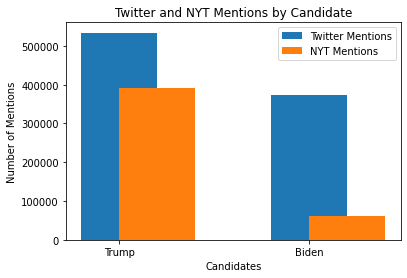

In [38]:
# Data Sources for Each Candidate
# Code from ChatGPT

import matplotlib.pyplot as plt

candidate = ['Trump','Biden']
twitter_n = [df_parquet_results_trump['source'].value_counts()[0],df_parquet_results_biden['source'].value_counts()[0]]
nyt_n = [df_parquet_results_trump['source'].value_counts()[1],df_parquet_results_biden['source'].value_counts()[1]]

x = range(len(candidate))

# Plotting the bars
plt.bar(x, twitter_n, width=0.4, label='Twitter Mentions', align='center')
plt.bar(x, nyt_n, width=0.4, label='NYT Mentions', align='edge')

# Adding labels
plt.xlabel('Candidates')
plt.ylabel('Number of Mentions')
plt.title('Twitter and NYT Mentions by Candidate')
plt.xticks(x, candidate)
plt.legend()

# Show plot
plt.savefig('DataDist.png')

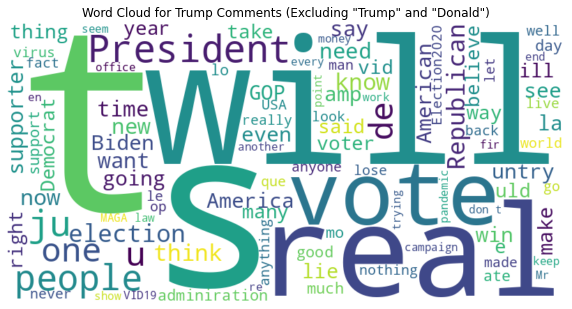

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Sample a subset of comments for generating the word cloud
sampled_trump_comments = df_parquet_results_trump['comment_body'].dropna().sample(n=10000, random_state=42)

# Concatenate sampled comments for Trump
trump_comments_text = ' '.join(sampled_trump_comments)

# Define words and patterns to exclude
words_to_exclude = ['trump', 'donald', 'donaldtrump', 'https', 'co', 'st'] 
patterns_to_exclude = [r'\btrump\b', r'\bdonald\b', r'\bdonaldtrump\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
trump_comments_text_cleaned = re.sub(exclude_patterns, '', trump_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Trump comments with a limit on the number of words
wordcloud_trump = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(trump_comments_text_cleaned)

# Plot the word cloud for Trump
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_trump, interpolation='bilinear')
plt.title('Word Cloud for Trump Comments (Excluding "Trump" and "Donald")')
plt.axis('off')
plt.show()

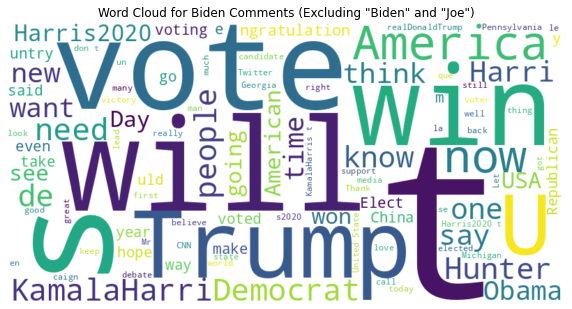

In [40]:
# Sample a subset of comments for Biden
sampled_biden_comments = df_parquet_results_biden['comment_body'].dropna().sample(n=40000, random_state=42)

# Concatenate sampled comments for Biden
biden_comments_text = ' '.join(sampled_biden_comments)

# Define words and patterns to exclude
words_to_exclude = ['biden', 'joe', 'joebiden', 'president', 'election', 'https', 'co','amp']  # Exclude common words and URLs
patterns_to_exclude = [r'\bbiden\b', r'\bjoe\b', r'\bjoebiden\b', r'https?://\S+']

# Combine words and patterns to exclude
exclude_patterns = '|'.join(words_to_exclude + patterns_to_exclude)

# Preprocess text to remove specific words and patterns
biden_comments_text_cleaned = re.sub(exclude_patterns, '', biden_comments_text, flags=re.IGNORECASE)

# Generate word cloud for Biden comments with a limit on the number of words
wordcloud_biden = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(biden_comments_text_cleaned)

# Plot the word cloud for Biden
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_biden, interpolation='bilinear')
plt.title('Word Cloud for Biden Comments (Excluding "Biden" and "Joe")')
plt.axis('off')
plt.show()

# Sentiment Labels Using Textblob

In [41]:
#pip install langdetect

In [42]:
#pip install fasttext-wheel

In [43]:
#Use pretrained model

!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin -P /ADS508_GroupProject
!ls /ADS508_GroupProject


--2024-03-24 01:21:13--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.39.82, 13.249.39.6, 13.249.39.89, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.39.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘/ADS508_GroupProject/lid.176.bin.5’

lid.176.bin.5       100%[===================>] 125.18M   158MB/s    in 0.8s    

2024-03-24 01:21:14 (158 MB/s) - ‘/ADS508_GroupProject/lid.176.bin.5’ saved [131266198/131266198]

lid.176.bin    lid.176.bin.2  lid.176.bin.4
lid.176.bin.1  lid.176.bin.3  lid.176.bin.5


In [44]:
import fasttext
from textblob import TextBlob

# Load the pre-trained language identification model
model_path = '/ADS508_GroupProject/lid.176.bin'  # Path to the pre-trained language identification model
model = fasttext.load_model(model_path)

In [50]:
# Function to detect language using FastText
def detect_language_fasttext(text):
    prediction = model.predict(text)
    language_code = prediction[0][0].split('__label__')[1]
    return language_code

# Function to analyze tweet sentiment to catch non english words
def analyze_tweet_sentiment(tweet_text):
    try:
        language = detect_language_fasttext(tweet_text)
        if language == 'en':
            analysis = TextBlob(tweet_text)
            return analysis.sentiment.polarity
        else:
            return None
    except:
        return None



In [51]:
# Apply sentiment analysis to Trump data
if __name__ == "__main__":
    
    df_parquet_results_trump['sentiment'] = df_parquet_results_trump['comment_body'].apply(analyze_tweet_sentiment)
    
    # Drop non-English tweets (NaN sentiment_score)
    df_parquet_results_trump.dropna(subset=['sentiment'], inplace=True)

In [52]:

# Biden 
df_parquet_results_biden['sentiment'] = df_parquet_results_biden['comment_body'].apply(analyze_tweet_sentiment)
    
# Count NaN values before dropping
num_nans_before_biden = df_parquet_results_biden['comment_body'].isna().sum()

# Drop non-English tweets (NaN sentiment_score)
df_parquet_results_biden.dropna(subset=['sentiment'], inplace=True)

   


/tmp/ipykernel_13214/311868631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_biden['sentiment'] = df_parquet_results_biden['comment_body'].apply(analyze_tweet_sentiment)
/tmp/ipykernel_13214/311868631.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parquet_results_biden.dropna(subset=['sentiment'], inplace=True)


In [55]:
df_parquet_results_biden

,comment_body,source,user_location,candidatepoll,sentiment
0,We can all breathe now . #Biden,tweet,NY 🍎 LA | 🌎 Traveler | Not All Those Who Wan,Biden,0.000000
1,#KamalaHarrisVP #JoeBiden JOE AND KAMALA DO ...,tweet,,Biden,0.330000
2,Thank you @KingJames @CP3 &amp; the sporting w...,tweet,,Biden,0.000000
3,"""@BBCNews #JoeBiden can we please savour this ...",tweet,158.0,Biden,0.000000
4,#Merkel #Allemagne #Biden https://t.co/fyq8r3siwN,tweet,"""Montréal",Biden,0.000000
...,...,...,...,...,...
489253,@Steve C. Biden's son was an adult. Do you bla...,nyt_comment,Forest Hills NY,Biden,0.150000
489254,"""Tying his fate to the anti-lockdown movement ...",nyt_comment,Syracuse,Biden,0.075000
489255,"""So how is it that the Democrats have selected...",nyt_comment,Seattle / Myrtle Beach,Biden,-0.099107
489256,I just want this election year to be OVER and ...,nyt_comment,Rockville Md,Biden,0.000000


In [ ]:
oo

In [ ]:
# Code from ChatGPT
#!pip install textblob
#from textblob import TextBlob

#def analyze_tweet_sentiment(tweet_text):
    #analysis = TextBlob(tweet_text)
    # Return sentiment polarity (ranging from -1 to 1)
    #return analysis.sentiment.polarity


In [ ]:
#Apply sentiment labels to Trump Data
#if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    #df_tweets_trump = df_parquet_results_trump[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    #df_tweets_trump['sentiment_score'] = df_tweets_trump['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
#df_parquet_results_trump['sentiment'] = df_tweets_trump['sentiment_score']



In [ ]:
 # Apply Sentiment labels to Biden Data       
#if __name__ == "__main__":
    # Assuming you have a DataFrame named df_tweets with a column 'text' containing tweet text
    #df_tweets_biden = df_parquet_results_biden[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    #df_tweets_biden['sentiment_score'] = df_tweets_biden['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
#df_parquet_results_biden['sentiment'] = df_tweets_biden['sentiment_score']


## Trump

In [ ]:
# Examine Trump Sentiment distribution
df_parquet_results_trump['sentiment'].value_counts()

In [ ]:
# look at sample of tweets for negative sentiment
df_parquet_results_trump[df_parquet_results_trump['sentiment'] < 0].head(5)

In [ ]:
# look at sample of tweets for neutral sentiment
df_parquet_results_trump[df_parquet_results_trump['sentiment'] == 0].head(5)

In [ ]:
# look at sample of tweets for positive sentiment
df_parquet_results_trump[df_parquet_results_trump['sentiment'] > 0].head(5)

In [ ]:
plt.hist(df_parquet_results_trump['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Trump')

# Show plot
plt.savefig('TrumpSentDist.png')

## Biden

In [ ]:
# Examine Biden Sentiment distribution
df_parquet_results_biden['sentiment'].value_counts()

In [ ]:
# look at sample of tweets for negative sentiment
df_parquet_results_biden[df_parquet_results_biden['sentiment'] < 0].head(5)

In [ ]:
# look at sample of tweets for neutral sentiment
df_parquet_results_biden[df_parquet_results_biden['sentiment'] == 0].head(5)

In [ ]:
# look at sample of tweets for positive sentiment
df_parquet_results_biden[df_parquet_results_biden['sentiment'] > 0].head(5)

In [ ]:
plt.hist(df_parquet_results_biden['sentiment'], bins=30, edgecolor='black')

# Adding labels
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Biden')

# Show plot
plt.savefig('BidenSentDist.png')

## Preliminary Location Maps of Social Media Activity

In [ ]:
# Color Sentiment on Scale from Blue to Red going dark to light as it approaches neutral

# Overlappint popular cities
trump_cities = []
biden_cities = []

# Plot sentiment for cities



# Data Bias

## Prepare Dataset for Bias Analysis

In [ ]:
#import boto3
#import sagemaker
#import pandas as pd

#sess = sagemaker.Session()
#bucket = sess.default_bucket()
#role = sagemaker.get_execution_role()
#region = boto3.Session().region_name
#account_id = boto3.client("sts").get_caller_identity().get("Account")

#sm = boto3.Session().client(service_name="sagemaker", region_name=region)

#from pyathena import connect

#s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
#database_name = "dbpoliticpulsecomment"
#conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

#from textblob import TextBlob

#def analyze_tweet_sentiment(tweet_text):
    #analysis = TextBlob(tweet_text)
    # Return sentiment polarity (ranging from -1 to 1)
    #return analysis.sentiment.polarity


# **********************DELETE PORTION ON THE TOP WHEN IT'S FINAL*************************



# We can just combine the df_parquet_results_biden and df_parquet_results_trump versus calling another query and running sentiment analysis again. Saves computational time.

In [ ]:
#table_comment = "comment"

#statement = """SELECT comment_body, source, candidatepoll FROM {}.{}
#WHERE candidatepoll is not Null
    #""".format(
    #database_name, table_comment
#)
#df_combined = pd.read_sql(statement, conn)
#df_combined = df_combined.drop_duplicates()
#df_combined.info()

In [ ]:
# Run sentiment analysis textblob for all candidate
#if __name__ == "__main__":
    # Assuming you have a DataFrame named df_comment with a column 'text' containing tweet text
    #df_comment_all = df_combined[['comment_body']]
    # Analyze sentiment for each tweet in the DataFrame
    #df_comment_all['sentiment_score'] = df_combined['comment_body'].apply(analyze_tweet_sentiment)

# Add sentiment output to parent dataframe
#df_combined['sentiment'] = df_comment_all['sentiment_score']


In [ ]:
df_combined = pd.concat([df_parquet_results_biden, df_parquet_results_trump], ignore_index=True)

In [ ]:
df_combined ['sentiment_category'] = df_combined['sentiment'].apply(lambda x: 'negative' if x < 0 else ('positive' if x > 0 else 'neutral'))

In [ ]:
import seaborn as sns
sns.countplot(data=df_combined, x="sentiment_category", hue="candidatepoll")
plt.title('Count Plot for Outcome Variable')  # Fixed typo here
plt.xlabel('Sentiment Categories for Candidates')
plt.ylabel('Count')
plt.show()  # Added to display the plot

# Feature Engineering and Data Preprocessing

## Create Outcome Labels: 6 Outcomes

In [ ]:
df_combined['SentimentOutcome'] = df_combined['candidatepoll']+"_"+df_combined['sentiment_category']

In [ ]:
# Create count plot
sns.countplot(x=df_combined['SentimentOutcome'])

# Add title and labels
plt.title('Count Plot for Outcome Variable')
plt.xlabel('Sentiment Categories for Candidates')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Location Data: Top 5 States

In [ ]:
# Read csv US City from S3 ---> PLANNING TO MOVE IT IN .py AND USE PREPROCESSING JOB FROM SAGEMAKER
git_city_loc = "https://raw.githubusercontent.com/HNStaggs/ADS508_GroupProject/main/uscities.csv"
df_city = pd.read_csv(git_city_loc)

df_combined['user_location'].head(5)

In [ ]:
# PREFER TO RUN IT IN .py with SageMaker processing job
# TRY IT WITH 100 RECORD ONLY


# Create master location table
master_location = df_city
df_combined = df_combined.head(100)

# Function to map city and state name to state ID
def map_state_id(city):
    for index, loc in master_location.iterrows():
        if city.lower() == loc['city'].lower() or city.lower() == loc['state_name'].lower():
            return loc['state_id']
    return None

# Apply mapping function to user location table
df_combined['State ID'] = df_combined['user_location'].apply(map_state_id)

# Display the user location table with State ID column added


In [ ]:
print(df_combined.head(100))


# Create Final Dataset of Features

In [ ]:
from collections import defaultdict
 
# Create ID variable
id_list = df_combined.index
temp = defaultdict(lambda: len(temp))
id_relabel = [temp[id] for id in id_list]
df_combined['review_id'] = pd.to_numeric(id_relabel)+1

# Create final dataset with outcome variable and comment body
df_final = df_combined[['review_id', 'comment_body', 'user_location', 'source', 'SentimentOutcome']]

In [ ]:
df_final.head()

# Store Final Data in S3 Bucket

In [ ]:
#Create folder
!mkdir -p ./data-clarify/

In [ ]:
# chatgpt
# list folder
import os

# Get the current working directory
current_directory = "/home/sagemaker-user/ADS508_GroupProject"

In [ ]:
# All Data
path = "./data-clarify/tweet_nyt_combined.csv"
df_final.to_csv(path, index=False, header=True)

In [ ]:
# Create folder for specific timestamp
import time

timestamp = int(time.time())

all_data_s3_uri = sess.upload_data(bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path)
all_data_s3_uri


In [ ]:
!aws s3 ls $all_data_s3_uri

# Text Preprocessing with DistilBERT and Train/Test/Split

In [ ]:
#!pip install transformers
import transformers
import tensorflow as tf
import collections
import json
import os
import pandas as pd
import csv
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
REVIEW_BODY_COLUMN = "comment_body"

# Update IDs to start from 1
from collections import defaultdict
 
REVIEW_ID_COLUMN = "review_id"

LABEL_COLUMN = "SentimentOutcome"
LABEL_VALUES = ['Bidennegative', 'Bidenneutral', 'Bidenpositive', 'Trumpnegative', 'Trumpneutral', 'Trumppositive']


In [ ]:
#!pygmentize preprocess-scikit-text-to-bert-feature-store.py

In [ ]:
import time
from smexperiments.experiment import Experiment

timestamp = int(time.time())

experiment = Experiment.create(
    experiment_name="PoliticPulse-BERT-Experiment-{}".format(timestamp),
    description="Politic Pulse BERT Experiment",
    sagemaker_boto_client=sm,
)

experiment_name = experiment.experiment_name
print("Experiment name: {}".format(experiment_name))

In [ ]:
from smexperiments.trial import Trial

trial = Trial.create(
    trial_name="trial-{}".format(timestamp), experiment_name=experiment_name, sagemaker_boto_client=sm
)

trial_name = trial.trial_name
print("Trial name: {}".format(trial_name))

In [ ]:
experiment_config = {
    "ExperimentName": experiment_name,
    "TrialName": trial_name,
    "TrialComponentDisplayName": "prepare",
}

In [ ]:
print(experiment_name)
%store experiment_name

In [ ]:
print(trial_name)
%store trial_name

In [ ]:
featurestore_runtime = boto3.Session().client(service_name="sagemaker-featurestore-runtime", region_name=region)

In [ ]:
feature_store_offline_prefix = "reviews-feature-store-" + str(timestamp)

print(feature_store_offline_prefix)

In [ ]:
feature_group_name = "reviews-feature-group-" + str(timestamp)

print(feature_group_name)

In [ ]:
from sagemaker.feature_store.feature_definition import (
    FeatureDefinition,
    FeatureTypeEnum,
)

feature_definitions = [
    FeatureDefinition(feature_name="input_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="input_mask", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="segment_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="label_id", feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name="review_id", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="date", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="label", feature_type=FeatureTypeEnum.INTEGRAL),
    #    FeatureDefinition(feature_name='review_body', feature_type=FeatureTypeEnum.STRING)
]

In [ ]:
from sagemaker.feature_store.feature_group import FeatureGroup

feature_group = FeatureGroup(name=feature_group_name, feature_definitions=feature_definitions, sagemaker_session=sess)

print(feature_group)

In [ ]:
processing_instance_type = "ml.c5.xlarge"
processing_instance_count = 2
train_split_percentage = 0.90
validation_split_percentage = 0.05
test_split_percentage = 0.05
balance_dataset = True
max_seq_length = 64

In [ ]:
from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    env={"AWS_DEFAULT_REGION": region},
    max_runtime_in_seconds=7200,
)

# Need to find preprocess file and update to our destination location

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

processor.run(
    code="preprocess-scikit-text-to-bert-feature-store.py",
    inputs=[
        ProcessingInput(
            input_name="raw-input-data",
            source=all_data_s3_uri,
            destination="/opt/ml/processing/input/data/",
            s3_data_distribution_type="ShardedByS3Key",
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="bert-train", s3_upload_mode="EndOfJob", source="/opt/ml/processing/output/bert/train"
        ),
        ProcessingOutput(
            output_name="bert-validation",
            s3_upload_mode="EndOfJob",
            source="/opt/ml/processing/output/bert/validation",
        ),
        ProcessingOutput(
            output_name="bert-test", s3_upload_mode="EndOfJob", source="/opt/ml/processing/output/bert/test"
        ),
    ],
    arguments=[
        "--train-split-percentage",
        str(train_split_percentage),
        "--validation-split-percentage",
        str(validation_split_percentage),
        "--test-split-percentage",
        str(test_split_percentage),
        "--max-seq-length",
        str(max_seq_length),
        "--balance-dataset",
        str(balance_dataset),
        "--feature-store-offline-prefix",
        str(feature_store_offline_prefix),
        "--feature-group-name",
        str(feature_group_name),
    ],
    experiment_config=experiment_config,
    logs=True,
    wait=False,
)

# Tranformation Pipeline

In [ ]:
cats_list = ['user_location', 'source']

# Create a categorical processing pipeline that uses one-hot encoding, dropping binary columns.
cat_pipe = Pipeline([('encoder', OneHotEncoder(drop='if_binary'))])

# Combine pipeline steps
all_pipe = make_pipeline(ColumnTransformer([('cat', cat_pipe, cats_list)],
                                          verbose_feature_names_out=False))
# Verify steps
all_pipe.named_steps

# Combine Transformed Features with BERT Transformed Text Data

# Make New Folders with Clean Datasets

In [ ]:
#Create folder
#!mkdir -p ./data-clarify/

In [ ]:
# chatgpt
# list folder
#import os

# Get the current working directory
#current_directory = "/home/sagemaker-user/ADS508_GroupProject"
#spec_dir = "/home/sagemaker-user/ADS508_GroupProject/data-clarify"

# List the contents of the directory
#for item in os.listdir(spec_dir):
    #full_path = os.path.join(spec_dir, item)
    #if os.path.isdir(full_path):
        #print(f"Directory: {item}")
    #else:
        #print(f"File: {item}")

In [ ]:
# All Data
#path = "./data-clarify/tweet_nyt_combined.csv"
#df_combined.to_csv(path, index=False, header=True)

In [ ]:
# Balance the Dataset by candidate and Sentiment score
#import matplotlib.pyplot as plt
#import seaborn as sns

#df_grouped_by = df_combined.groupby(["candidatepoll", "sentiment_category"])[["candidatepoll", "sentiment_category"]]
#df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))
#df_balanced.shape

#sns.countplot(data=df_balanced, x="sentiment_category", hue="candidatepoll")

In [ ]:
#path_balance = "./data-clarify/combine_balance.csv"
#df_balanced.to_csv(path_balance, index=False, header=True)

#path_jsonlines = "./data-clarify/combine_balance.jsonl"
#df_balanced.to_json(path_or_buf=path_jsonlines, orient="records", lines=True)

### Upload Combined and Balance Data to S3

In [ ]:
# Create folder for specific timestamp
import time

timestamp = int(time.time())

bias_data_s3_uri = sess.upload_data(bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path)
bias_data_s3_uri

In [ ]:
!aws s3 ls $bias_data_s3_uri

In [ ]:
balanced_bias_data_s3_uri = sess.upload_data(
    bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path_balance
)
balanced_bias_data_s3_uri

In [ ]:
!aws s3 ls $balanced_bias_data_s3_uri

In [ ]:
balanced_bias_data_jsonlines_s3_uri = sess.upload_data(
    bucket=bucket, key_prefix="ADS508_project/bias-detection-{}".format(timestamp), path=path_jsonlines
)
balanced_bias_data_jsonlines_s3_uri

In [ ]:
!aws s3 ls $balanced_bias_data_jsonlines_s3_uri

## Run Data Bias Analysis

In [ ]:
#!pip install --force-reinstall -q smclarify

from smclarify.bias import report
from typing import Dict
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!aws s3 cp $bias_data_s3_uri ./data-clarify/

In [ ]:
!aws s3 cp $balanced_bias_data_s3_uri ./data-clarify/

### Calculate Bias Metrics for all Data
#### might not needed from ===>

facet_column = report.FacetColumn(name="candidatepoll")

label_column = report.LabelColumn(
    name="sentiment_category", 
    series=df_combined["sentiment_category"],
    positive_label_values=[5]
)

In [ ]:
report.bias_report(
    df=df_combined, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

### Calculate Bias Metrics for Balanced Data

In [ ]:
from smclarify.bias import report

facet_column = report.FacetColumn(name="candidatepoll")

label_column = report.LabelColumn(
    name="sentiment_category", 
    series=df_balanced["sentiment_category"], 
    positive_label_values=[5]
)

In [ ]:
report.bias_report(
    df=df_balanced, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

#### <=== TO MIGHT NOT NEEDED

### Run Data Bias Analysis (Pre-training)

In [ ]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.c5.xlarge", 
    sagemaker_session=sess
)

#### Pre-Training Bias

In [ ]:
bias_report_output_path = "s3://{}/ADS508_project/clarify".format(bucket)

bias_data_config = clarify.DataConfig(
    s3_data_input_path=bias_data_s3_uri,
    s3_output_path=bias_report_output_path,
    label="sentiment_category",
    headers=df_combined.columns.to_list(),
    dataset_type="text/csv",
)


In [ ]:
# Trump
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5],
    facet_name="candidatepoll",
    facet_values_or_threshold=["Trump"],
)

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name



In [ ]:
# Biden
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5],
    facet_name="candidatepoll",
    facet_values_or_threshold=["Biden"],
)

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name


#### Download report

In [ ]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, run_pre_training_bias_processing_job_name
        )
    )
)

from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, run_pre_training_bias_processing_job_name, region
        )
    )
)

In [ ]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=run_pre_training_bias_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()

print(processing_job_description)

In [ ]:
!aws s3 ls $bias_report_output_path/

In [ ]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/

In [ ]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/report.html">Bias Report</a></b>'))

In [ ]:
path = "./data-clarify/amazon_reviews_us_giftcards_software_videogames.csv"
df.to_csv(path, index=False, header=True)

In [ ]:
_testing